In [ ]:
!pip install tensorflow==2.8.0
!pip install np_utils
!pip install keras

In [ ]:
import os
from glob import glob
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Activation,Dense, Dropout, Flatten

import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from keras.models import Model

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imageSize=128
train_dir = "/content/drive/MyDrive/Foot_Ulcer/Train"
test_dir =  "/content/drive/MyDrive/Foot_Ulcer/Test"
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):

            if folderName in ['MAL']:
                label = 0
            elif folderName in ['BEN']:
                label = 1
                '''
            elif folderName in ['Opacity']:
                label = 2
            elif folderName in ['pneumonia']:
                label = 3
                '''
            else:
                label = 4

            for image_filename in tqdm(os.listdir(folder + '/'+folderName)):


                img_file = cv2.imread(folder + '/'+folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)

                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)

    return X,y
X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)


100%|██████████| 100/100 [00:01<00:00, 56.37it/s]


In [ ]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
num_classes = 2
model = AlexNet((imageSize, imageSize, 3), num_classes)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         132

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory("/content/drive/MyDrive/Foot_Ulcer/Train",
                                                 target_size = (imageSize, imageSize),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/Foot_Ulcer/Test",
                                            target_size = (imageSize, imageSize),
                                            batch_size =8,
                                            class_mode = 'categorical')

Found 1024 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
epochs=30

In [ ]:
history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=epochs,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
64/64 [==============================] - 22s 133ms/step - loss: 1.0310 - tp: 512.0000 - fp: 512.0000 - tn: 512.0000 - fn: 512.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - auc: 0.5166 - val_loss: 0.6935 - val_tp: 100.0000 - val_fp: 100.0000 - val_tn: 100.0000 - val_fn: 100.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5000
Epoch 2/30
64/64 [==============================] - 11s 166ms/step - loss: 0.6937 - tp: 492.0000 - fp: 532.0000 - tn: 492.0000 - fn: 532.0000 - accuracy: 0.4805 - precision: 0.4805 - recall: 0.4805 - auc: 0.4703 - val_loss: 0.6930 - val_tp: 100.0000 - val_fp: 100.0000 - val_tn: 100.0000 - val_fn: 100.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5000
Epoch 3/30
64/64 [==============================] - 8s 120ms/step - loss: 0.7003 - tp: 558.0000 - fp: 466.0000 - tn: 558.0000 - fn: 466.0000 - accuracy: 0.5449 - precision: 0.5449 - recall: 0.5449 - auc: 0.5666 - v

In [ ]:
# Evaluate model
score = model.evaluate(test_set,verbose=0)
print('\nKeras CNN - accuracy:', score[5], '\n')


Keras CNN - accuracy: 0.5 



In [ ]:
model.save("alexnet.h5")

In [ ]:
score

[0.6891182065010071,
 100.0,
 100.0,
 100.0,
 100.0,
 0.5,
 0.5,
 0.5,
 0.6074999570846558]

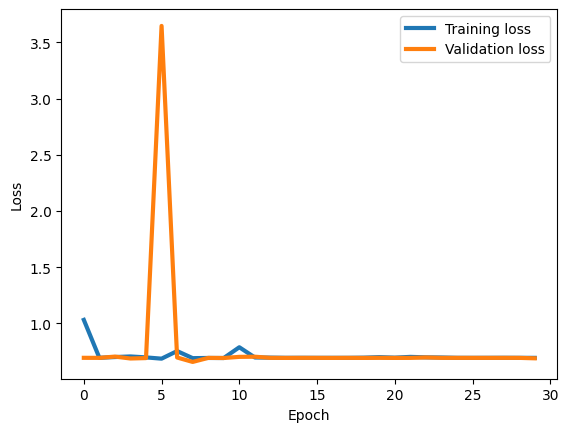

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='Training loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation loss', linewidth=3)
plt.xlabel('Epoch'); plt.ylabel('Loss');
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

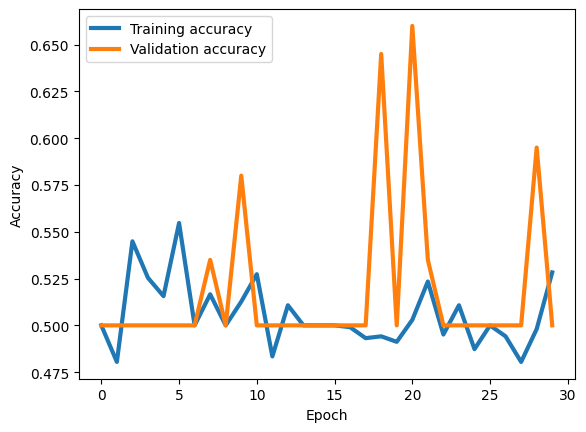

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='Training accuracy', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation accuracy', linewidth=3)
plt.xlabel('Epoch'); plt.ylabel('Accuracy');
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
Y_pred=model.predict(test_set)
y_pred=np.argmax(Y_pred,axis=1)

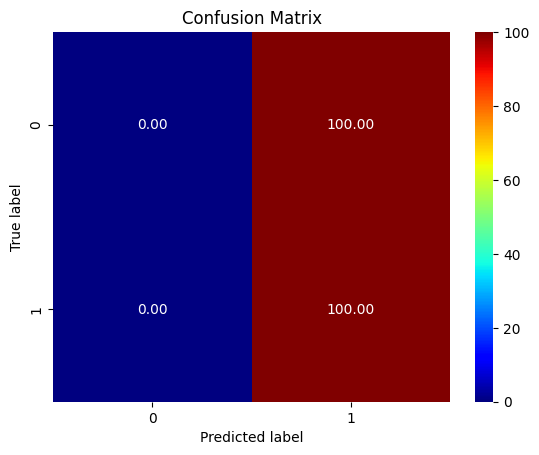

In [ ]:
cm=confusion_matrix(test_set.classes,y_pred)
f = sns.heatmap(cm, annot=True, fmt='.2f',cmap='jet')
f.set_xlabel('Predicted label');f.set_ylabel('True label');
f.set_title('Confusion Matrix');

In [ ]:
# Extracting Intermediate Layers Output

In [ ]:
from keras.models import Model

In [ ]:
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         132

In [ ]:
##### Checking and extracting the indexes of "Convolutional Layers"
t=list(model.layers)
conv_index=[]
for i in range(len(t)):
  layer=t[i]
  if 'conv' in layer.name:
    conv_index.append(i)

print("Indexes of Convolutional Layers are ",conv_index)

Indexes of Convolutional Layers are  [0, 2, 4, 5, 6]
